In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

# Set defaults for charts so they aren't so tiny!
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,5]

import numpy
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pprint import pprint
import math
import pandas as pd
import csv
import sklearn.covariance
import scipy.optimize
import sklearn.linear_model
import scipy.stats

In [2]:
with open('prior_weight_results.csv', 'rt') as file:
    reader = csv.DictReader(file)
    results = list([dict(item) for item in reader])
    
results = [{key:(float(item) if '.' in item else item) for key,item in result.items()} for result in results]
for result in results:
    result['stdvsmedian'] = result['std'] / result['median']
    result['stdvsmin'] = result['std'] / result['min']

    
nonFeatureKeys=['gamma', 'loss', 'min', 'median', 'max', 'best', 'bestSize', 'predicted']
lossKeys = ['n_prior_weight_0.5', 
            'n_prior_weight_0.6',
            'n_prior_weight_0.7',
            'n_prior_weight_0.8',
            'n_prior_weight_0.9',
            'n_prior_weight_1.0', 
            'n_prior_weight_1.1',
            'n_prior_weight_1.2',
            'n_prior_weight_1.3',
            'n_prior_weight_1.4',
            'n_prior_weight_1.5']

for result in results:
    best = min(lossKeys, key=lambda key: result[key])
    result['best'] = best
    result['bestSize'] = float(best[len('n_prior_weight_'):])
    
    
features = [{key:value for key,value in result.items() if key not in nonFeatureKeys} for result in results]
pd.DataFrame(features)

,best/median,contributions_exponential,contributions_linear,contributions_logarithmic,contributions_peakvalley,contributions_random,interactions,interactions_index,interactions_linear,interactions_peakvalley,...,n_prior_weight_1.2,n_prior_weight_1.3,n_prior_weight_1.4,n_prior_weight_1.5,num_parameters,range,skew,std,stdvsmedian,stdvsmin
0,0.883386,0.3,0.2,0.2,0.2,0.1,28,0.933333,0.285714,0.464286,...,0.247477,0.249706,0.248257,0.247644,10,0.363729,1.865960,0.041887,0.147657,0.167256
1,0.889793,0,0.25,0.25,0.5,0,15,0.781250,0.4,0.133333,...,0.233516,0.234764,0.234213,0.234653,8,0.333333,1.567408,0.041675,0.156919,0.176495
2,0.710934,0.166667,0.333333,0,0.333333,0.166667,8,0.740741,0.375,0.25,...,0.183370,0.177038,0.179142,0.175505,6,0.410470,1.444423,0.082534,0.287429,0.403943
3,0.756086,0.333333,0,0.333333,0,0.333333,1,0.370370,0,1,...,0.131925,0.133585,0.140063,0.134223,3,0.364750,1.862107,0.107303,0.592137,0.787817
4,0.812728,0.1,0.4,0.2,0.2,0.1,29,0.966667,0.241379,0.275862,...,0.237347,0.238148,0.232438,0.234981,10,0.376401,1.584574,0.057940,0.203537,0.250579
5,0.879761,0.25,0.125,0.25,0.0625,0.3125,78,1.015625,0.269231,0.269231,...,0.301126,0.301189,0.299151,0.303688,16,0.396034,1.603416,0.042311,0.126358,0.143684
6,0.773501,0,0.25,0.25,0.25,0.25,0,0.208333,0,0,...,0.065186,0.065683,0.065453,0.064392,4,0.131770,1.672942,0.026545,0.306543,0.396373
7,0.741582,0.111111,0,0.333333,0.333333,0.222222,22,0.905350,0.272727,0.227273,...,0.191033,0.196163,0.194383,0.187907,9,0.348625,1.531557,0.063369,0.254905,0.343692
8,0.821248,0.4,0,0.2,0.3,0.1,22,0.733333,0.363636,0.318182,...,0.226516,0.234832,0.236725,0.233968,10,0.380437,1.539794,0.060624,0.213318,0.259633
9,0.787894,0,1,0,0,0,0,0.370370,0,0,...,0.047219,0.046849,0.047894,0.047119,3,0.116498,2.005351,0.030701,0.506178,0.648958


In [17]:
sizes = [result['bestSize'] for result in results]

averageSize = numpy.max(sizes)

ax, fig = plt.subplots()

fig.hist(sizes)

fig


<IPython.core.display.Javascript object>

In [4]:
counts = {}
for key in lossKeys:
    counts[key]=0
for result in results:
    counts[result['best']] += 1


pprint(counts)

{'n_prior_weight_0.5': 44,
 'n_prior_weight_0.6': 39,
 'n_prior_weight_0.7': 38,
 'n_prior_weight_0.8': 48,
 'n_prior_weight_0.9': 43,
 'n_prior_weight_1.0': 52,
 'n_prior_weight_1.1': 44,
 'n_prior_weight_1.2': 39,
 'n_prior_weight_1.3': 61,
 'n_prior_weight_1.4': 47,
 'n_prior_weight_1.5': 45}


<IPython.core.display.Javascript object>


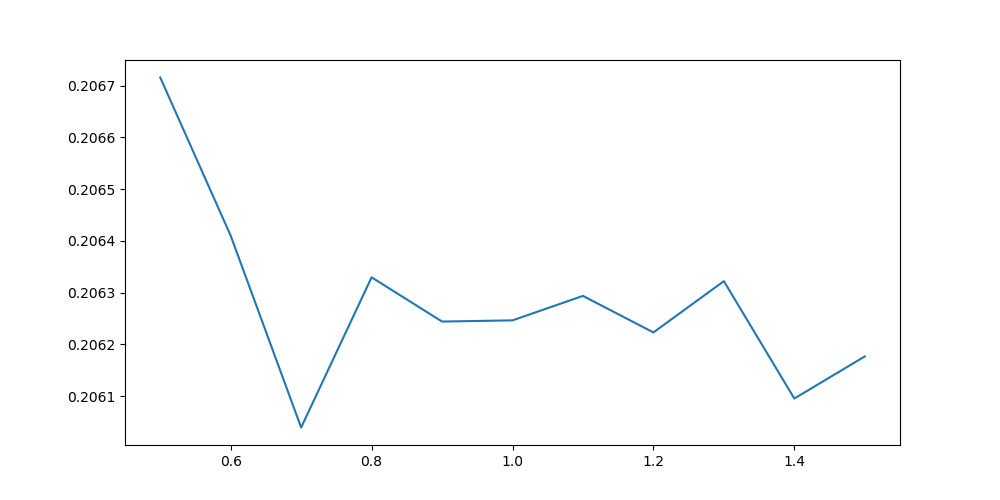

In [18]:
averageLoss = {}

for key in lossKeys:
    length = float(key[len('n_prior_weight_'):])
    averageLoss[length] = numpy.mean([result[key] for result in results])


averageLoss
ax, fig = plt.subplots()
fig.plot(averageLoss.keys(), averageLoss.values())
fig

In [19]:
labels = [key for key in results[0].keys() if key not in nonFeatureKeys and key not in lossKeys]

bestSizes = [result['bestSize'] for result in results]

correlations = []
for label in labels:
    vector = [result[label] for result in results]
    correlation = scipy.stats.spearmanr(vector, bestSizes)[0]
    correlations.append({'name': label, 'correlation': correlation})

    
with open('correls.csv', 'wt') as file:
    writer = csv.DictWriter(file, fieldnames=['name','correlation'])
    writer.writeheader()
    writer.writerows(correlations)


correlations = list(sorted(correlations, key=lambda r:-abs(r['correlation'])))
pd.DataFrame(correlations)

/home/bradley/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,correlation,name
0,-0.075541,interactions_wave
1,-0.074756,best/median
2,0.067480,contributions_logarithmic
3,0.067200,stdvsmin
4,0.064327,stdvsmedian
5,-0.058374,contributions_linear
6,0.053197,std
7,-0.050654,interactions_index
8,0.042445,num_parameters
9,0.037677,interactions_peakvalley


In [20]:
def plot(variable, rounding, lim=None):
    pairs = [(float(round(result[variable]*rounding)/rounding), float(result['bestSize'])) for result in results]
    pairs = sorted(pairs, key=lambda r:r[0])
    bestSizes = [p[1] for p in pairs]
    values = [p[0] for p in pairs]
    
    means = []
    meanValues = []
    allValues = set(values)
    for v in sorted(allValues):
        valueBestSizes = [bestSizes[i] for i in range(len(bestSizes)) if '{:.3E}'.format(values[i]) == '{:.3E}'.format(v)]
        meanValues.append(v)
        means.append(numpy.mean(valueBestSizes))
    
    ax, fig = plt.subplots()
    fig.set_xlabel(variable)
    fig.set_ylabel('n_prior_weight')
    fig.set_xticks(numpy.linspace(numpy.min(values),numpy.max(values),10))
    fig.set_yticks(numpy.linspace(0,2,10))
    fig.set_ylim(0, 2)
    if lim:
        fig.set_xlim(0, lim)
    fig.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    fig.xaxis.set_major_formatter(mticker.ScalarFormatter())
    fig.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    fig.yaxis.set_major_formatter(mticker.ScalarFormatter())
    fig.scatter(values, bestSizes)
    fig.plot(meanValues, means, 'r')
    return fig

<IPython.core.display.Javascript object>


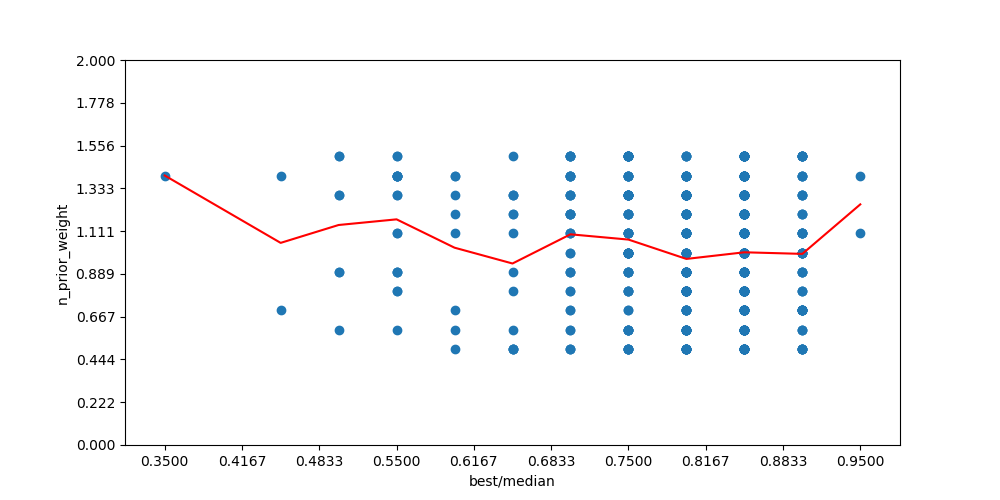

In [26]:
plot('best/median', 20)

In [9]:
plot('stdvsmin', 0.1, 1.7)

<IPython.core.display.Javascript object>

In [10]:
plot('stdvsmedian', 0.1, 2)

<IPython.core.display.Javascript object>

In [11]:
plot('std', 0.01, 0.15)

<IPython.core.display.Javascript object>

In [12]:
plot('skew', 0.3)

<IPython.core.display.Javascript object>

In [13]:
fields = sorted(results[0].keys())
fields = [field for field in fields if 'contributions' not in field and 'interactions' not in field and field not in lossKeys and field not in nonFeatureKeys]
vectors = [[float(result[f]) for f in fields] for result in features]
n_EI_candidates = [result['bestSize'] for result in results]
deviations = numpy.std(vectors, axis=0)
covarianceModel = sklearn.covariance.LedoitWolf()
covarianceModel.fit(numpy.array(vectors), numpy.array(n_EI_candidates))
deviations = numpy.std(vectors, axis=0)

rows = []
for i,l in enumerate(fields):
    data = {fields[k]:round(100*(covarianceModel.covariance_[i][k] / (deviations[i] * deviations[k]))) if k!= i else '' for k in range(len(fields))}
    data ['field'] = fields[i]
    rows.append(data)
pd.DataFrame(rows)

,best/median,field,kurtosis,log10_cardinality,num_parameters,range,skew,std,stdvsmedian,stdvsmin
0,,best/median,-15,62,63,41,-19,-65,-65,-73
1,-15,kurtosis,,-43,-44,-14,96,33,51,43
2,62,log10_cardinality,-43,,98,24,-52,-69,-60,-56
3,63,num_parameters,-44,98,,23,-52,-72,-62,-58
4,41,range,-14,24,23,,-14,14,-28,-30
5,-19,skew,96,-52,-52,-14,,44,58,50
6,-65,std,33,-69,-72,14,44,,70,65
7,-65,stdvsmedian,51,-60,-62,-28,58,70,,96
8,-73,stdvsmin,43,-56,-58,-30,50,65,96,


In [14]:
ax, fig = plt.subplots()
fig.scatter([result['log10_cardinality'] for result in results], [result['stdvsmedian'] for result in results])

<IPython.core.display.Javascript object>

In [15]:
predictors = ['log10_cardinality']

filteredResults = results

vectors = [[float(round(result[predictor]*10))/10 for predictor in predictors] for result in filteredResults]
n_EI_candidates = [result['bestSize'] for result in filteredResults]

def fit_function(x, a, b, c):
    log10_cardinality = x
    res= a*numpy.power(10, b*log10_cardinality)+c
    return res[:,0]


ax, fig = plt.subplots()
fig.scatter(vectors, n_EI_candidates)
fig

params = scipy.optimize.curve_fit(fit_function, vectors, n_EI_candidates, p0=(1, -1.0e-1, 3))[0]
params

TypeError: type str doesn't define __round__ method

In [ ]:
def rp(number, precision=1):
    """ Rounds the given floating point number to a certain precision, for output."""
    return str(float(('{:.' + str(precision) + 'E}').format(number)))

equation = "n_EI_candidates = " + rp(params[2], 1)
equation += " + " + rp(params[0]) + " * 10 ^ (" + rp(params[1]) + " * log10_cardinality)"
print(equation)

In [ ]:
def predict(stdvsmedian):
    predicted = params[0] * math.pow(10,(params[1] * stdvsmedian)) + params[2]
    return predicted

    
values = numpy.linspace(0, 30, 25)
candidates = [predict(card) for card in values]

ax, nfig = plt.subplots()
nfig.scatter(values, candidates)
nfig